In [1]:
import torch as t
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from nlp_moe_model import MoEBertModel, MoETextModel
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os


# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 3e-5
NUM_EXPERTS = 8
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
ROUTING = 'hard'  # 'soft' or 'hard' or 'gumbel'
TOP_K = 3 # Only used if ROUTING is 'hard'
FREEZE_BERT = True  # Whether to freeze BERT layers during training

def plot_confusion_matrix(y_true, y_pred, class_names, save_path='metrics/confusion_matrix.png', hyperparams=None):
    """Plot confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    fig = plt.gcf()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # Add hyperparameters text box
    if hyperparams:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        fig.text(0.02, 0.98, hyperparams, transform=fig.transFigure,
                 fontsize=9, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to {save_path}")

def plot_training_history(train_losses, train_accs, test_losses, test_accs, save_path='metrics/training_history.png', hyperparams=None):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, test_losses, 'r-', label='Test Loss', linewidth=2)
    ax1.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Accuracy', linewidth=2)
    ax2.plot(epochs, test_accs, 'r-', label='Test Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    # Add hyperparameters text box
    if hyperparams:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        fig.text(0.02, 0.98, hyperparams, transform=fig.transFigure,
                 fontsize=9, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Training history saved to {save_path}")

def plot_per_class_metrics(y_true, y_pred, class_names, save_path='metrics/per_class_metrics.png', hyperparams=None):
    """Plot per-class precision, recall, and F1-score"""
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred, average=None)

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(15, 6))
    ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    ax.bar(x, recall, width, label='Recall', alpha=0.8)
    ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

    ax.set_xlabel('Classes')
    ax.set_ylabel('Scores')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    # Add hyperparameters text box
    if hyperparams:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        fig.text(0.02, 0.98, hyperparams, transform=fig.transFigure,
                 fontsize=9, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Per-class metrics saved to {save_path}")

def analyze_expert_usage(model, dataloader, device, num_experts, num_classes):
    """Analyze which experts are used for each class"""
    model.eval()

    # Track expert usage per class: [num_classes, num_experts]
    expert_usage = np.zeros((num_classes, num_experts))
    class_counts = np.zeros(num_classes)

    with t.no_grad():
        for batch in tqdm(dataloader, desc="Analyzing expert usage"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Get BERT embeddings
            bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = bert_output.pooler_output

            # Get routing weights from the MoE layer
            routing_weights = model.router(input_ids=input_ids, attention_mask=attention_mask)  # [batch_size, num_experts]

            # For soft routing, use the weights directly
            # For hard/top-k routing, you'll need to adapt based on your implementation
            if model.routing == 'soft':
                expert_probs = t.softmax(routing_weights, dim=-1)
            else:
                # For top-k, get which experts were selected
                top_k_values, top_k_indices = t.topk(routing_weights, model.top_k, dim=-1)
                expert_probs = t.zeros_like(routing_weights)
                expert_probs.scatter_(1, top_k_indices, t.softmax(top_k_values, dim=-1))

            # Accumulate expert usage per class
            for i, label in enumerate(labels):
                label_idx = label.item()
                expert_usage[label_idx] += expert_probs[i].cpu().numpy()
                class_counts[label_idx] += 1

    # Normalize by class counts
    for i in range(num_classes):
        if class_counts[i] > 0:
            expert_usage[i] /= class_counts[i]

    return expert_usage

def plot_expert_usage_heatmap(expert_usage, class_names, save_path='metrics/expert_usage_heatmap.png', hyperparams=None):
    """Plot heatmap showing expert usage per class"""
    plt.figure(figsize=(12, max(8, len(class_names) * 0.4)))

    sns.heatmap(expert_usage,
                annot=True,
                fmt='.3f',
                cmap='YlOrRd',
                xticklabels=[f'Expert {i}' for i in range(expert_usage.shape[1])],
                yticklabels=class_names,
                cbar_kws={'label': 'Average Usage Weight'})
    fig = plt.gcf()
    # Add hyperparameters text box
    if hyperparams:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        fig.text(0.02, 0.98, hyperparams, transform=fig.transFigure,
                 fontsize=9, verticalalignment='top', bbox=props)


    plt.title('Expert Usage by Class', fontsize=14, fontweight='bold')
    plt.xlabel('Experts')
    plt.ylabel('Classes')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Expert usage heatmap saved to {save_path}")

def plot_expert_specialization(expert_usage, class_names, save_path='metrics/expert_specialization.png',hyperparams=None):
    """Plot which classes each expert specializes in"""
    num_experts = expert_usage.shape[1]

    fig, axes = plt.subplots(2, (num_experts + 1) // 2, figsize=(15, 8))
    axes = axes.flatten()

    for expert_idx in range(num_experts):
        ax = axes[expert_idx]
        usage = expert_usage[:, expert_idx]

        # Sort classes by usage
        sorted_indices = np.argsort(usage)[::-1][:5]  # Top 5 classes

        ax.barh(range(len(sorted_indices)), usage[sorted_indices])
        ax.set_yticks(range(len(sorted_indices)))
        ax.set_yticklabels([class_names[i] for i in sorted_indices], fontsize=8)
        ax.set_xlabel('Usage Weight', fontsize=9)
        ax.set_title(f'Expert {expert_idx}', fontsize=10, fontweight='bold')
        ax.invert_yaxis()

    # Hide extra subplots if odd number of experts
    for i in range(num_experts, len(axes)):
        axes[i].axis('off')

    # Add hyperparameters text box
    if hyperparams:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        fig.text(0.02, 0.98, hyperparams, transform=fig.transFigure,
                 fontsize=9, verticalalignment='top', bbox=props)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Expert specialization saved to {save_path}")

def get_hyperparameters_text():
    return f"""Hyperparameters:
Batch Size: {BATCH_SIZE}
Epochs: {EPOCHS}
Learning Rate: {LEARNING_RATE}
Number of Experts: {NUM_EXPERTS}
Model Name: {MODEL_NAME}
Max Length: {MAX_LEN}
Routing: {ROUTING}
Top K: {TOP_K}
Freeze BERT: {FREEZE_BERT}
"""

/home/knwldgosint/Documents/Projects/analysis/rocm_env/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['HIP_VISIBLE_DEVICES'] = '0'   # AMD ROCm
# Custom Dataset for News
class NewsDataset(Dataset):
    def __init__(self, texts, labels, sentiments, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sentiments = sentiments
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        sentiment = self.sentiments[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': t.tensor(label, dtype=t.long),
            'sentiment': t.tensor(sentiment, dtype=t.long)
        }

def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    label_encoder = LabelEncoder()
    sentiment_encoder = LabelEncoder()
    train_df['label_encoded'] = label_encoder.fit_transform(train_df['Class Index'])
    test_df['label_encoded'] = label_encoder.transform(test_df['Class Index'])
    train_df['Sentiment_encoded'] = sentiment_encoder.fit_transform(train_df['Sentiment'])
    test_df['Sentiment_encoded'] = sentiment_encoder.transform(test_df['Sentiment'])
    return train_df, test_df, label_encoder, sentiment_encoder

def train_epoch(model, dataloader, optimizer, criterion, device, load_balance=False,balance_coef=0.01):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        sentiment = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        if load_balance:
            # Get routing weights
            bert_output = model.bert(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = bert_output.pooler_output
            gate=model.gating_network(pooled_output)
            gate_probs = t.softmax(gate, dim=-1)

            #MSE loss to encourage balanced expert usage
            avg_expert_usage = gate_probs.mean(dim=0)
            uniform_target= t.ones_like(avg_expert_usage)/avg_expert_usage.size(0)
            balance_loss = t.nn.functional.mse_loss(avg_expert_usage, uniform_target)

            # Entropy
            entropy = -t.sum(gate_probs * t.log(gate_probs + 1e-10), dim=1).mean()
            balance_loss += 0.1 * entropy
            loss += balance_coef * balance_loss
        else:
            pass

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device, return_predictions=False):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with t.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            if return_predictions:
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

    if return_predictions:
        return total_loss / len(dataloader), correct / total, all_predictions, all_labels
    return total_loss / len(dataloader), correct / total


Using device: cuda:0
GPU Name: AMD Radeon RX 7900 XTX
GPU Count: 1
Number of classes: 4
Number of sentiment classes: 2


2026-01-15 17:09:56.422202: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-15 17:09:56.446649: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-15 17:09:57.158909: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



Epoch 1/5


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.90it/s]


Train Loss: 0.5814, Train Acc: 0.7984
Test Loss: 0.3975, Test Acc: 0.8591
Model saved!

Epoch 2/5


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.84it/s]


Train Loss: 0.4633, Train Acc: 0.8439
Test Loss: 0.3910, Test Acc: 0.8593
Model saved!

Epoch 3/5


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.88it/s]


Train Loss: 0.4411, Train Acc: 0.8522
Test Loss: 0.3633, Test Acc: 0.8691
Model saved!

Epoch 4/5


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.89it/s]


Train Loss: 0.4293, Train Acc: 0.8564
Test Loss: 0.3423, Test Acc: 0.8753
Model saved!

Epoch 5/5


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.81it/s]


Train Loss: 0.4175, Train Acc: 0.8599
Test Loss: 0.3527, Test Acc: 0.8724

Best Test Accuracy: 0.8753

Generating Analytics...


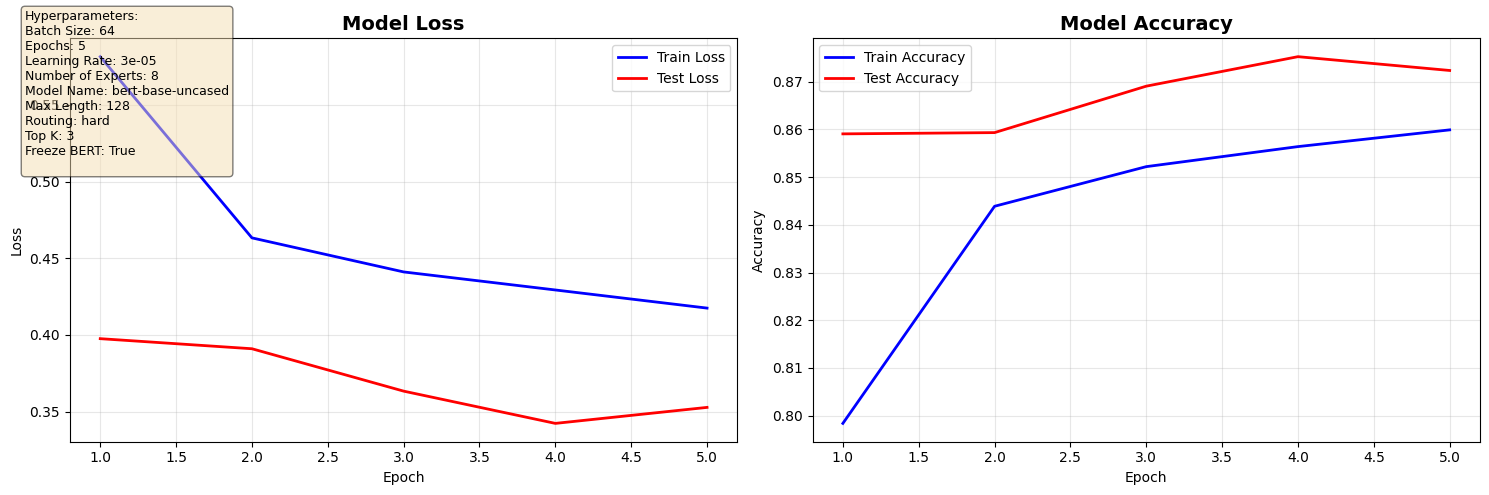

Training history saved to metrics/training_history.png


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.85it/s]


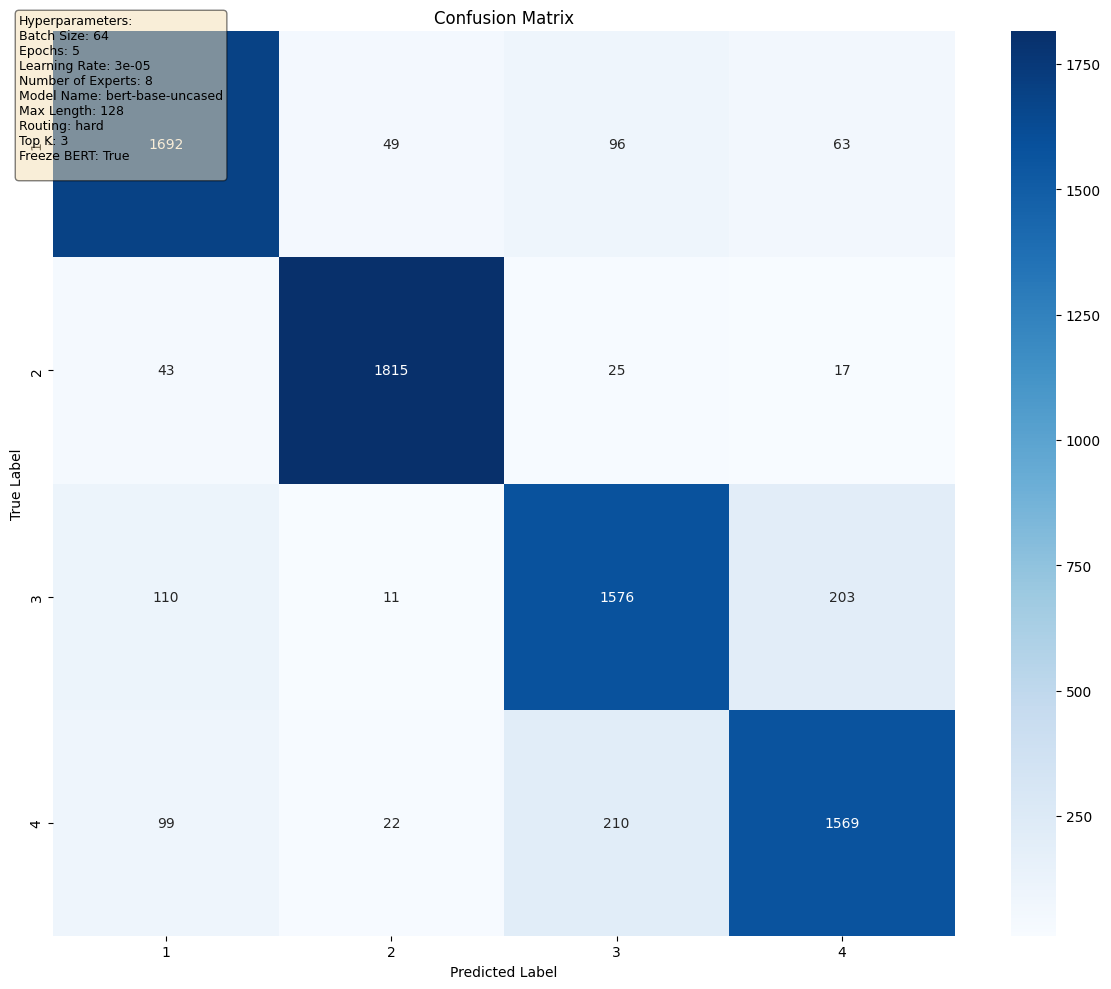

Confusion matrix saved to metrics/confusion_matrix.png


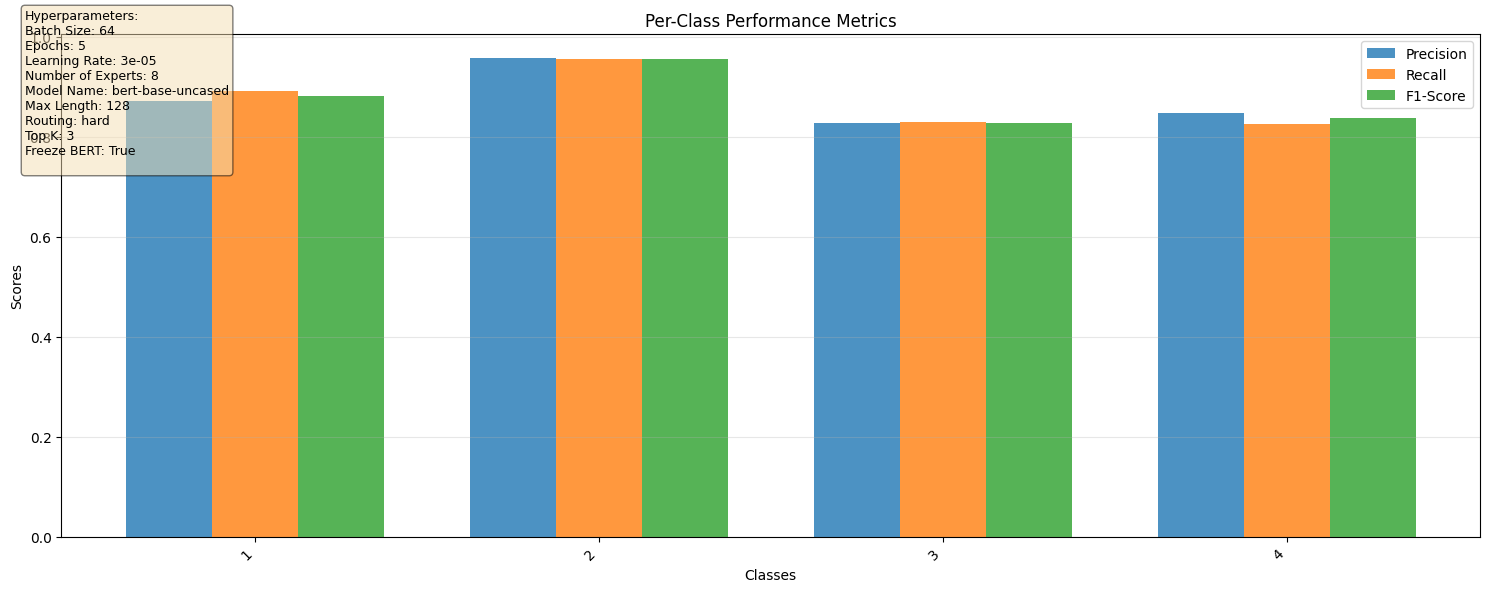

Per-class metrics saved to metrics/per_class_metrics.png

Classification Report:
              precision    recall  f1-score   support

           1       0.87      0.89      0.88      1900
           2       0.96      0.96      0.96      1900
           3       0.83      0.83      0.83      1900
           4       0.85      0.83      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600


Analyzing Expert Usage...


Analyzing expert usage: 100%|██████████| 119/119 [00:18<00:00,  6.58it/s]


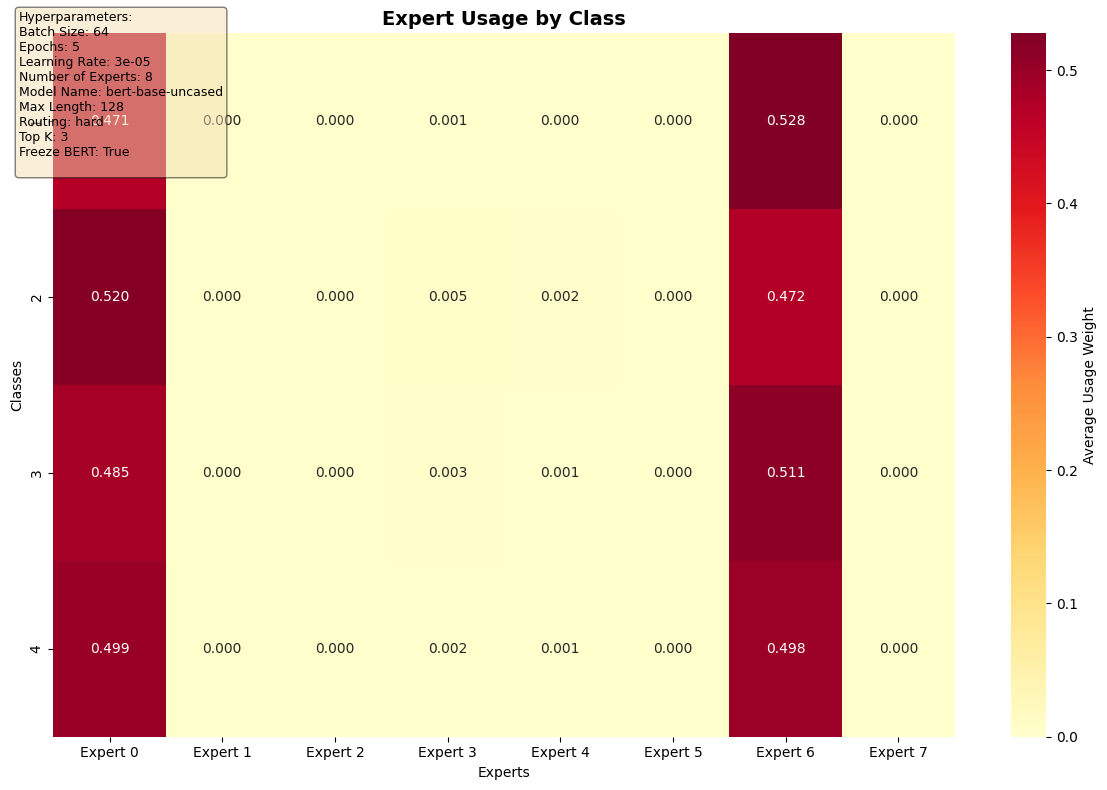

Expert usage heatmap saved to metrics/expert_usage_heatmap.png


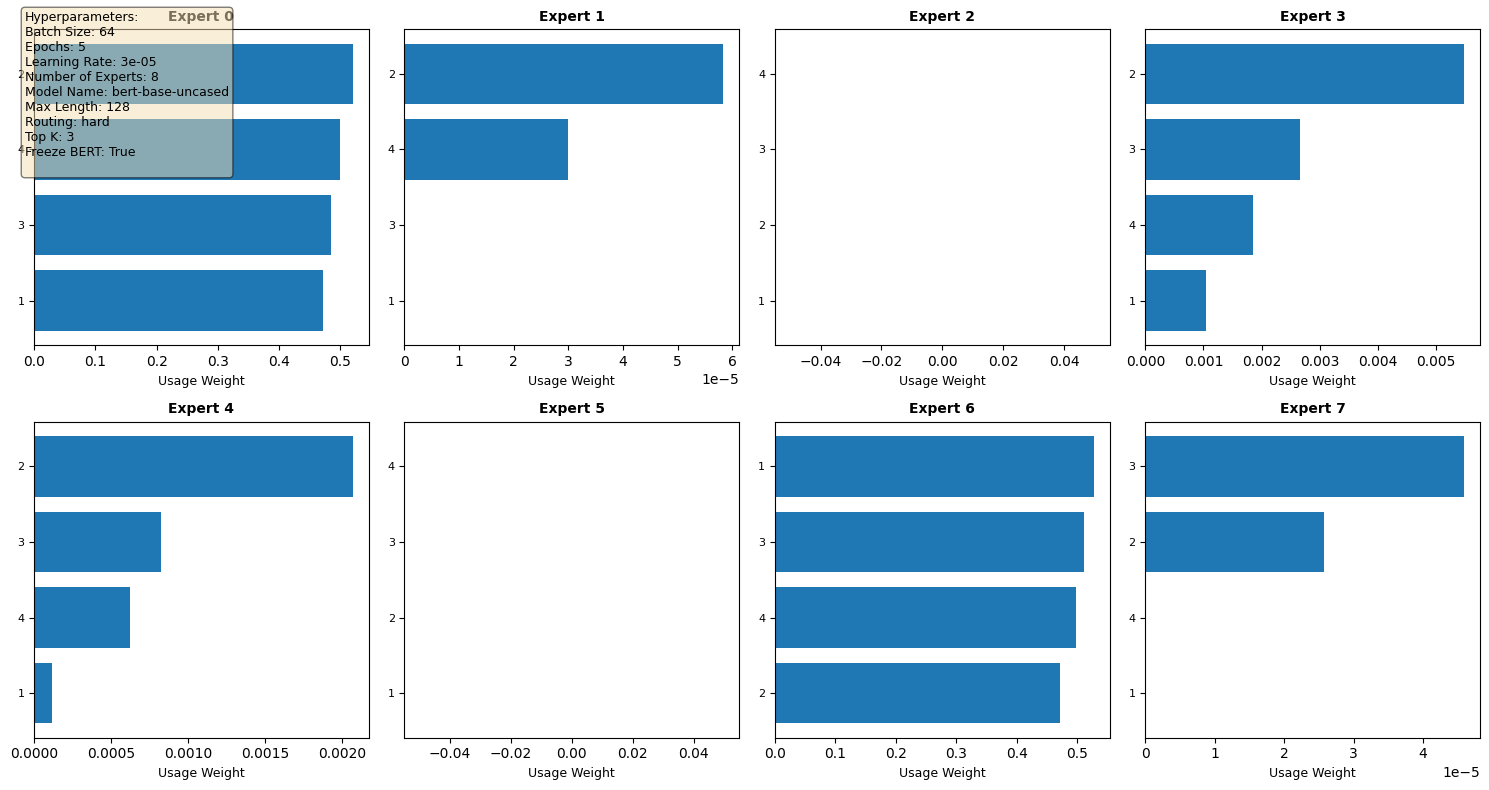

Expert specialization saved to metrics/expert_specialization.png

Top 3 Experts per Class:
1: Experts [6 0 3] with weights [0.52751037 0.47132333 0.00105091]
2: Experts [0 6 3] with weights [0.52007862 0.47228095 0.00548636]
3: Experts [6 0 3] with weights [0.51129976 0.48516359 0.00266768]
4: Experts [0 6 3] with weights [0.49920236 0.49828312 0.00185967]


In [3]:
def main(model_type='bert'):
    # Configuration
    device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print(f"GPU Name: {t.cuda.get_device_name(0)}")
    print(f"GPU Count: {t.cuda.device_count()}")

    # Forcer toutes les opérations sur ce GPU
    t.cuda.set_device(0)


    # Load data
    train_df, test_df, label_encoder, sentiment_encoder = load_data(
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/train_with_sentiment.csv',
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/test_with_sentiment.csv'
    )
    num_classes = len(label_encoder.classes_)
    num_sentiments = len(sentiment_encoder.classes_)
    print(f"Number of classes: {num_classes}")
    print(f"Number of sentiment classes: {num_sentiments}")


    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

    # Create datasets
    train_dataset = NewsDataset(
        train_df['Description'].tolist(),
        train_df['label_encoded'].tolist(),
        train_df['Sentiment_encoded'].tolist(),
        tokenizer,
        max_length=MAX_LEN
    )
    test_dataset = NewsDataset(
        test_df['Description'].tolist(),
        test_df['label_encoded'].tolist(),
        test_df['Sentiment_encoded'].tolist(),
        tokenizer,
        max_length=MAX_LEN
    )

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
    model = None
    # Model
    # if model_type == 'bert':
    model = MoEBertModel(
        pretrained_model_name=MODEL_NAME,
        expert_number=NUM_EXPERTS,
        output_dim=num_classes,
        routing = ROUTING,
        top_k = TOP_K,
        freeze_bert = FREEZE_BERT,
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    best_acc = 0
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    hyperparam = get_hyperparameters_text()

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")

        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device, load_balance=True, balance_coef=0.3)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            t.save(model.state_dict(), 'best_moe_model.pth')
            print("Model saved!")

    print(f"\nBest Test Accuracy: {best_acc:.4f}")

    # Generate analytics plots
    print("\n" + "="*50)
    print("Generating Analytics...")
    print("="*50)

    # Plot training history
    plot_training_history(train_losses, train_accs, test_losses, test_accs, hyperparams=hyperparam)

    # Load best model for final evaluation
    model.load_state_dict(t.load('best_moe_model.pth'))

    # Get predictions for confusion matrix
    _, _, test_predictions, test_labels = evaluate(
        model, test_loader, criterion, device, return_predictions=True
    )

    # Get class names
    class_names = [str(cls) for cls in label_encoder.classes_]

    # Plot confusion matrix
    plot_confusion_matrix(test_labels, test_predictions, class_names, hyperparams=hyperparam)

    # Plot per-class metrics
    plot_per_class_metrics(test_labels, test_predictions, class_names, hyperparams=hyperparam)

    # Print classification report
    print("\nClassification Report:")
    print("="*50)
    print(classification_report(test_labels, test_predictions, target_names=class_names))

    # Analyze expert usage per class
    print("\n" + "="*50)
    print("Analyzing Expert Usage...")
    print("="*50)

    expert_usage = analyze_expert_usage(
        model, test_loader, device, NUM_EXPERTS, num_classes
    )

    # Plot expert usage heatmap
    plot_expert_usage_heatmap(expert_usage, class_names, hyperparams=hyperparam)

    # Plot expert specialization
    plot_expert_specialization(expert_usage, class_names, hyperparams=hyperparam)

    # Print top experts for each class
    print("\nTop 3 Experts per Class:")
    print("="*50)
    for i, class_name in enumerate(class_names):
        top_experts = np.argsort(expert_usage[i])[::-1][:3]
        print(f"{class_name}: Experts {top_experts} with weights {expert_usage[i][top_experts]}")

    t.cuda.empty_cache()

main()
